## Multi-Input Text Explanation: Textual Entailment with Facebook BART


This notebook demonstrates how to get explanations for the output of BART trained on the mnli dataset and used for textual entailment. 


In [1]:
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import shap
from datasets import load_dataset

### Load model and tokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli", use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# testing tokenizer
s1 = 'I ate some pie.'
s2 = 'You are a dog.'

s_combined = tokenizer(s1, s2)['input_ids']
print(s_combined)

s_decoded = tokenizer.decode(s_combined)
print(s_decoded)

s_one = tokenizer(s1 + '</s></s>' + s2)
print(s_one)

[0, 100, 14964, 103, 11637, 4, 2, 2, 1185, 32, 10, 2335, 4, 2]
<s>I ate some pie.</s></s>You are a dog.</s>
{'input_ids': [0, 100, 14964, 103, 11637, 4, 2, 2, 1185, 32, 10, 2335, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [4]:
# dataset
dataset = load_dataset("snli")
print(dataset)

example_ind = 6
premise, hypothesis, label = dataset['train']['premise'][example_ind], dataset['train']['hypothesis'][example_ind], dataset['train']['label'][example_ind]
print(premise)
print(hypothesis)
print(label)
# p2, h2, l2 = (
#     dataset["train"]["premise"][example_ind + 1],
#     dataset["train"]["hypothesis"][example_ind + 1],
#     dataset["train"]["label"][example_ind + 1]
# )
# print(p2)
# print(h2)
# print(l2)


input_ids = tokenizer.encode(premise, hypothesis, return_tensors='pt')
print(input_ids)
logits = model(input_ids)[0]

probs = logits.softmax(dim=1)
p1, p2, p3 = probs[:,0].item() * 100, probs[:,1].item()*100, probs[:,2].item()*100
print('Contradiction Probability: {p1:0.2f}%, Neutral Probability: {p2:0.2f}%, Entailment Probability: {p3:0.2f}%'.format(p1 = p1, p2 = p2, p3=p3))
ind_to_label = {0: 'entailment', 1: 'neural', 2: 'contradiction'}
true_label = ind_to_label[label]
print('The true label is: {true_label}'.format(true_label=true_label))

Reusing dataset snli (C:\Users\v-jocelinsu\.cache\huggingface\datasets\snli\plain_text\1.0.0\bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c)


DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})
A boy is jumping on skateboard in the middle of a red bridge.
The boy skates down the sidewalk.
2
tensor([[    0,   250,  2143,    16,  9755,    15, 12800,  4929,    11,     5,
          1692,     9,    10,  1275,  4081,     4,     2,     2,   133,  2143,
          2972,  1626,   159,     5, 15032,     4,     2]])
Contradiction Probability: 99.95%, Neutral Probability: 0.03%, Entailment Probability: 0.02%
The true label is: contradiction


In [5]:
# candidate_labels = ['travel', 'cooking', 'dancing', 'exploration']
# label = candidate_labels[0]
# premise = 'I want to go to Japan.'
# hypothesis = f'This example is {label}.'

In [6]:
import scipy as sp
import torch

def f(x): # TODO takes in the already - masked string which is the concatenation of 2 strings
    tv = torch.tensor([tokenizer.encode(_x) for _x in x])
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [7]:
print('EXPLAINER')
explainer = shap.Explainer(f, tokenizer)

encoded = tokenizer(premise, hypothesis)['input_ids'][1:-1]
decoded = tokenizer.decode(encoded)
print(decoded)

EXPLAINER
A boy is jumping on skateboard in the middle of a red bridge.</s></s>The boy skates down the sidewalk.


explainers.Partition is still in an alpha state, so use with caution...


In [8]:
shap_values = explainer([decoded]) # wrap in list, otherwise zip would iterate across letters
print('SHAP VALUES')
print(shap_values)

Partition explainer: 2it [00:27, 27.50s/it]                                                                            

SHAP VALUES
.values =
array([[[-1.97328143e-02,  7.36486093e-02, -2.42517870e-01],
        [-1.97328143e-02,  7.36486093e-02, -2.42517870e-01],
        [-1.97328143e-02,  7.36486093e-02, -2.42517870e-01],
        [-1.97328143e-02,  7.36486093e-02, -2.42517870e-01],
        [ 4.76632901e-02, -4.57190182e-02, -6.23079912e-02],
        [ 4.76632901e-02, -4.57190182e-02, -6.23079912e-02],
        [-7.82758575e-01,  5.22523442e-01,  2.56501220e-01],
        [-7.82758575e-01,  5.22523442e-01,  2.56501220e-01],
        [ 3.56486602e-01, -2.54778087e-01, -3.86819989e-01],
        [ 3.56486602e-01, -2.54778087e-01, -3.86819989e-01],
        [ 6.25450788e-01, -4.70197290e-01, -6.32266417e-01],
        [ 6.25450788e-01, -4.70197290e-01, -6.32266417e-01],
        [ 5.63202636e-01, -4.65998700e-01, -4.47784823e-01],
        [ 5.63202636e-01, -4.65998700e-01, -4.47784823e-01],
        [ 5.63202636e-01, -4.65998700e-01, -4.47784823e-01],
        [ 5.63202636e-01, -4.65998700e-01, -4.47784823e-01],
  

In [18]:
print(len(encoded))


25


## Sentence Partition Tree - Dendrogram

In [31]:
contradiction_ind = 0
inp = shap_values[0][:,contradiction_ind].abs
print(inp.clustering)

[[0.0e+00 1.0e+00 0.0e+00 2.0e+00]
 [2.0e+00 3.0e+00 1.3e+01 2.0e+00]
 [4.0e+00 5.0e+00 1.3e+01 2.0e+00]
 [6.0e+00 7.0e+00 0.0e+00 2.0e+00]
 [8.0e+00 9.0e+00 1.3e+01 2.0e+00]
 [1.0e+01 1.1e+01 1.3e+01 2.0e+00]
 [1.2e+01 1.3e+01 1.3e+01 2.0e+00]
 [1.7e+01 1.8e+01 0.0e+00 2.0e+00]
 [1.9e+01 2.0e+01 1.3e+01 2.0e+00]
 [2.1e+01 2.2e+01 1.3e+01 2.0e+00]
 [2.3e+01 2.4e+01 1.3e+01 2.0e+00]
 [3.3e+01 1.4e+01 1.4e+01 3.0e+00]
 [2.7e+01 2.8e+01 1.5e+01 4.0e+00]
 [2.9e+01 3.0e+01 1.5e+01 4.0e+00]
 [3.1e+01 3.2e+01 1.5e+01 4.0e+00]
 [3.4e+01 3.5e+01 1.5e+01 4.0e+00]
 [3.6e+01 3.7e+01 1.5e+01 4.0e+00]
 [3.8e+01 1.5e+01 0.0e+00 4.0e+00]
 [4.3e+01 2.5e+01 0.0e+00 5.0e+00]
 [3.9e+01 4.0e+01 1.9e+01 8.0e+00]
 [4.1e+01 4.4e+01 1.9e+01 8.0e+00]
 [4.2e+01 4.5e+01 0.0e+00 9.0e+00]
 [4.6e+01 4.7e+01 2.7e+01 1.6e+01]
 [4.8e+01 2.6e+01 4.1e+01 1.0e+01]
 [4.9e+01 1.6e+01 4.8e+01 1.7e+01]
 [5.1e+01 5.0e+01 1.0e+10 2.7e+01]]


In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [32]:
Z = np.array(inp.clustering)#.astype(int)

In [33]:
Z[-1][2] = 55
Z

array([[ 0.,  1.,  0.,  2.],
       [ 2.,  3., 13.,  2.],
       [ 4.,  5., 13.,  2.],
       [ 6.,  7.,  0.,  2.],
       [ 8.,  9., 13.,  2.],
       [10., 11., 13.,  2.],
       [12., 13., 13.,  2.],
       [17., 18.,  0.,  2.],
       [19., 20., 13.,  2.],
       [21., 22., 13.,  2.],
       [23., 24., 13.,  2.],
       [33., 14., 14.,  3.],
       [27., 28., 15.,  4.],
       [29., 30., 15.,  4.],
       [31., 32., 15.,  4.],
       [34., 35., 15.,  4.],
       [36., 37., 15.,  4.],
       [38., 15.,  0.,  4.],
       [43., 25.,  0.,  5.],
       [39., 40., 19.,  8.],
       [41., 44., 19.,  8.],
       [42., 45.,  0.,  9.],
       [46., 47., 27., 16.],
       [48., 26., 41., 10.],
       [49., 16., 48., 17.],
       [51., 50., 55., 27.]])

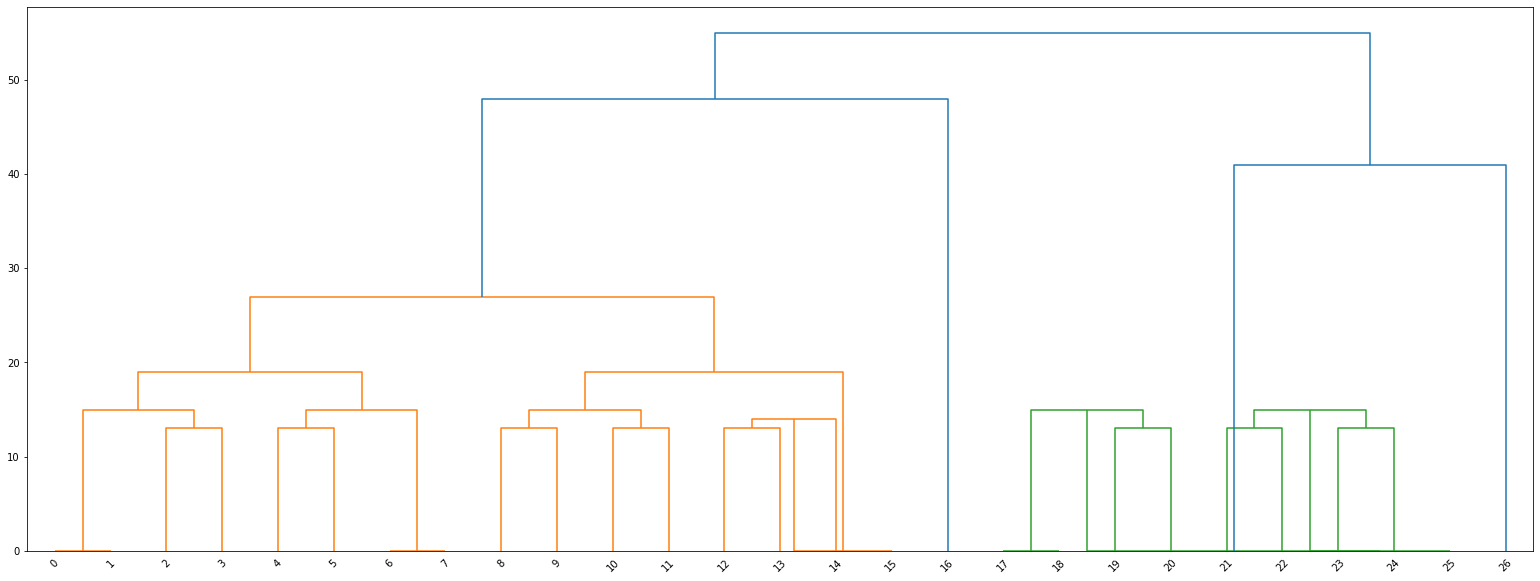

In [30]:
fig = plt.figure(figsize=(len(Z) + 1, 10))
dn = dendrogram(Z)
plt.show()

In [34]:
# what Max got
Z = np.array([[ 0.,  1., 12.,  2.],
       [ 2.,  3., 12.,  2.],
       [ 4.,  5., 12.,  2.],
       [ 6.,  7., 12.,  2.],
       [ 8.,  9., 12.,  2.],
       [10., 11., 12.,  2.],
       [12., 13., 12.,  2.],
       [16., 17., 12.,  2.],
       [18., 19., 12.,  2.],
       [20., 21., 12.,  2.],
       [22., 23., 12.,  2.],
       [33., 14., 13.,  3.],
       [37., 24., 13.,  3.],
       [27., 28., 14.,  4.],
       [29., 30., 14.,  4.],
       [31., 32., 14.,  4.],
       [34., 35., 14.,  4.],
       [38., 15., 15.,  4.],
       [36., 39., 15.,  5.],
       [45., 25., 17.,  6.],
       [40., 41., 18.,  8.],
       [42., 44., 18.,  8.],
       [43., 46., 20., 10.],
       [47., 48., 26., 16.],
       [49., 26., 41., 11.],
       [50., 51., 57., 27.]])
print(Z.shape)

(26, 4)


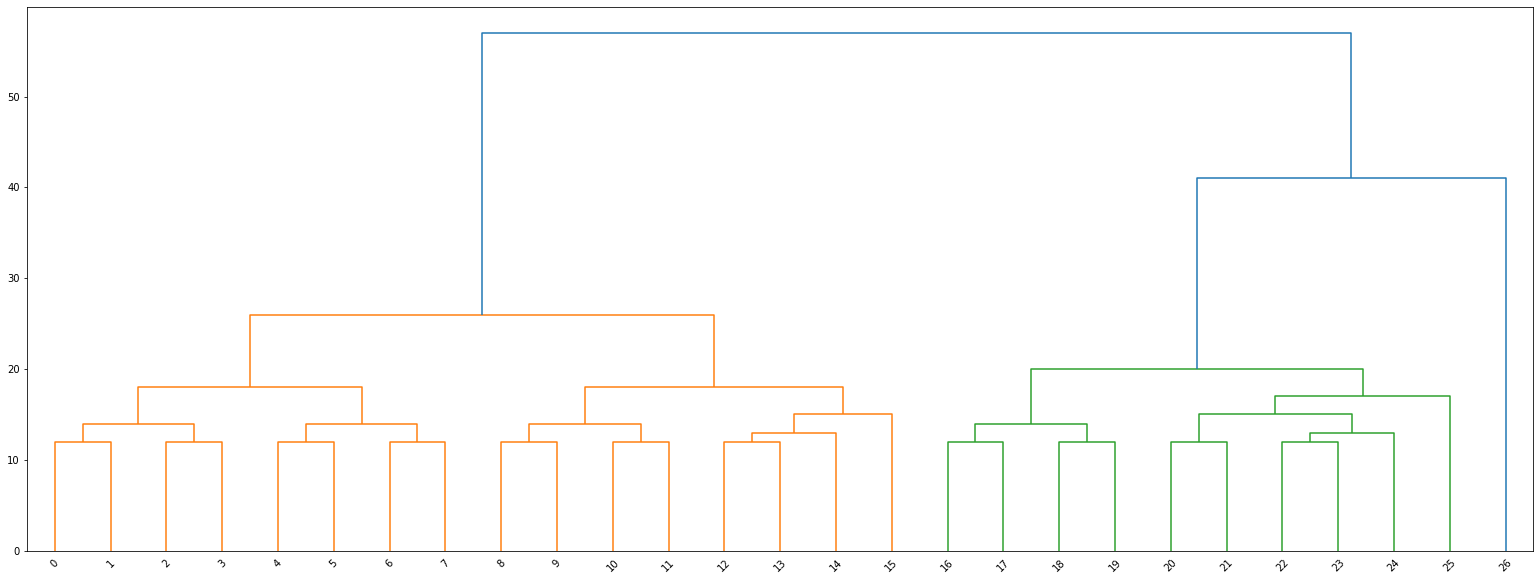

In [37]:
fig = plt.figure(figsize=(len(Z) + 1, 10))
dn = dendrogram(Z)
plt.show()

In [35]:
# what I got
Z2 = [[ 0.,  1.,  2.,  2.],
       [ 2.,  3.,  2.,  2.],
       [ 4.,  5.,  2.,  2.],
       [ 6.,  7.,  2.,  2.],
       [ 8.,  9.,  2.,  2.],
       [10., 11.,  2.,  2.],
       [12., 13.,  2.,  2.],
       [17., 18.,  2.,  2.],
       [19., 20.,  2.,  2.],
       [21., 22.,  2.,  2.],
       [23., 24.,  2.,  2.],
       [33., 14.,  3.,  3.],
       [27., 28.,  4.,  4.],
       [29., 30.,  4.,  4.],
       [31., 32.,  4.,  4.],
       [34., 35.,  4.,  4.],
       [36., 37.,  4.,  4.],
       [38., 15.,  5.,  4.],
       [43., 25.,  6.,  5.],
       [39., 40.,  8.,  8.],
       [41., 44.,  8.,  8.],
       [42., 45.,  9.,  9.],
       [46., 47., 16., 16.],
       [48., 26., 30., 10.],
       [49., 16., 37., 17.],
       [ 51.,  50.,  50.,  27.]]

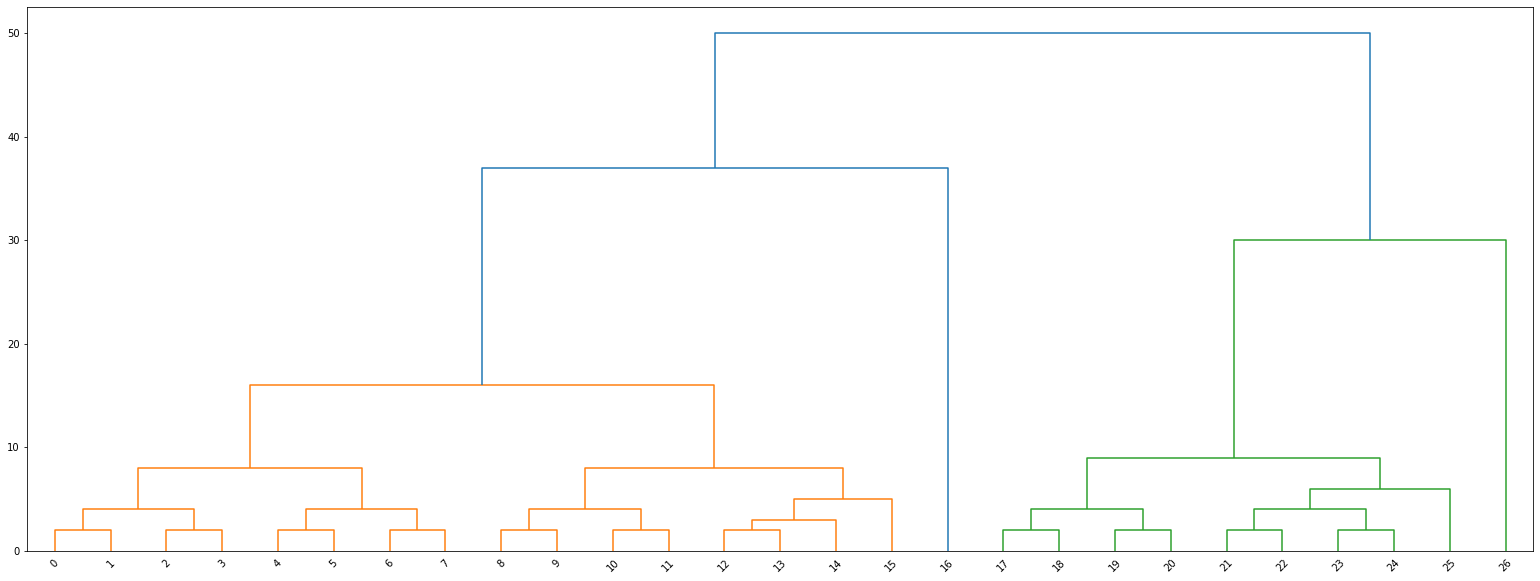

In [36]:
fig = plt.figure(figsize=(len(Z2) + 1, 10))
dn = dendrogram(Z2)
plt.show()

In [8]:
sort_order = 'positive'
perturbation = 'keep'

In [12]:
from shap import benchmark

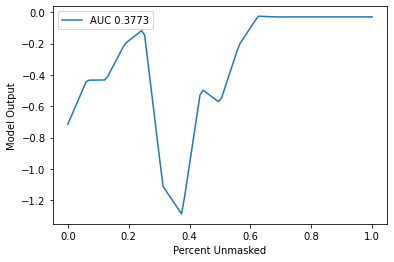

In [15]:
sper = benchmark.perturbation.SequentialPerturbation(explainer.model, explainer.masker, sort_order, perturbation)
xs, ys, auc = sper.model_score(shap_values, [decoded])
sper.plot(xs, ys, auc)